In [ ]:
# NLP
import spacy
spacy.cli.download("en_core_web_sm")

# Data manipulation
import numpy as np
import pandas as pd
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Reducer
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.model_selection import train_test_split
import string
import re
import emoji

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models I will try
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Models evalutations
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importation of the dataset

In [20]:
nlp = spacy.load("en_core_web_sm")

df_path= "../../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype(str)

## Preprocessing définitions

In [19]:
def emoji_processing(X: DataFrame) -> DataFrame:
	def count_emojis(text: str) -> int:
		return sum(1 for char in text if char in emoji.EMOJI_DATA)

	def replace_emojis(text: str) -> str:
		return emoji.demojize(text, delimiters=(" ", " "))
	
	X = X.copy()
	X["emoji_count"] = X["text"].apply(count_emojis)
	X["text"] = X["text"].apply(replace_emojis)
	return X
	
def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', '[url]', text)
	
	X = X.copy()
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link)
	return X

def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X = X.copy()
	X["text"] = X["text"].apply(preprocess)
	return X

In [14]:
def display_result(predicted_y, true_y ):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    cm = confusion_matrix(true_y, predicted_y)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non science related", "Science related"],
            yticklabels=["Non science related", "Science related"], ax=axes[0])

    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_title("Confusion Matrix")

    target_names = ['Non science related', 'Science related']
    class_report = classification_report(true_y, predicted_y, labels=[0, 1], target_names=target_names)

    axes[1].text(0, 0.5, class_report, fontsize=12, family='monospace')
    axes[1].axis("off")
    axes[1].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

## Preprocess the data

In [21]:
df = df_base.copy()
df = emoji_processing(df)
df = link_processing(df)
df = pre_processing(df)

In [22]:
X = df.copy().drop(columns=["scientific_claim", "scientific_reference", "scientific_context"])
y = X.pop("science_related")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.2)

X_train.head()

,text,emoji_count,link_count
938,.@frontier_usyd host frontotemporal dementia f...,0,1
470,people stop interfere people business winkin...,8,0
326,underwear stop fly,0,0
406,@martinhanratty @atyhans @thenotimer listen go...,0,0
953,truth untold stop play light turn green url,0,1


In [27]:
def vectorize_text(X):
	vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,4))
	return vectorizer.fit_transform(X)

X_tfidf = vectorize_text(X_train['text'])

X_pca shape: (912, 2)
y_train length: 912
y_test length: 228


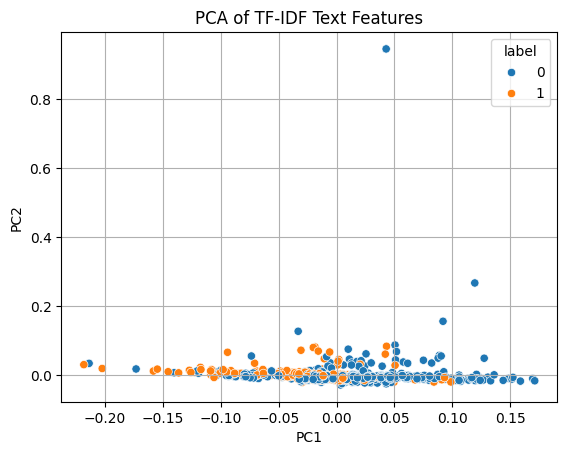

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'label': y_train.values
})

sns.scatterplot(data=df, x='PC1', y='PC2', hue='label')
plt.title("PCA of TF-IDF Text Features")
plt.grid(True)
plt.show()